In [26]:
import os
import math
import random
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]


Parametrization and loss function

In [27]:
def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    std=torch.exp(0.5 * logvar)
    eps=torch.randn_like(std)
    return mu + eps * std

def vae_loss_fn(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    recon_x_flat=recon_x.view(recon_x.shape[0], -1)
    x_flat=x.view(x.shape[0], -1)
    recon_loss=F.binary_cross_entropy(recon_x_flat, x_flat, reduction='sum') / x.shape[0]
    kl_element=-0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss=kl_element.sum(dim=1).mean()
    total=recon_loss + kl_loss
    return total, recon_loss, kl_loss


1.VAE with FC layers

In [4]:
class FCVAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dims: List[int], latent_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        enc_layers = []
        in_dim = input_dim
        for h in hidden_dims:
            enc_layers.append(nn.Linear(in_dim, h))
            enc_layers.append(nn.ReLU())
            in_dim = h
        self.encoder = nn.Sequential(*enc_layers)
        self.fc_mu = nn.Linear(in_dim, latent_dim)
        self.fc_logvar = nn.Linear(in_dim, latent_dim)
        dec_layers = []
        in_dim = latent_dim
        for h in reversed(hidden_dims):
            dec_layers.append(nn.Linear(in_dim, h))
            dec_layers.append(nn.ReLU())
            in_dim = h
        dec_layers.append(nn.Linear(in_dim, input_dim))
        dec_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*dec_layers)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


2.Convolutional VAE

In [5]:
# Cell 5: Convolutional VAE
class ConvVAE(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        # Encoder: Input 1x28x28
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1)  # -> 32 x 14 x 14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # -> 64 x 7 x 7

        # flatten 64*7*7 -> FC1 (256) -> FC2 (128) -> mu / logvar
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # Decoder: FC -> FC -> reshape -> Deconv -> Deconv
        self.fc3 = nn.Linear(latent_dim, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 64 * 7 * 7)

        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # -> 32 x 14 x 14
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1)   # -> 1 x 28 x 28

        self.act = nn.ReLU()
        self.out_act = nn.Sigmoid()

    def encode(self, x):
        h = self.act(self.conv1(x))
        h = self.act(self.conv2(h))
        h = h.view(h.size(0), -1)
        h = self.act(self.fc1(h))
        h = self.act(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        h = self.act(self.fc3(z))
        h = self.act(self.fc4(h))
        h = self.act(self.fc5(h))
        h = h.view(-1, 64, 7, 7)
        h = self.act(self.deconv1(h))
        h = self.out_act(self.deconv2(h))
        return h

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar


In [6]:
def train_vae(model: nn.Module, dataloader: DataLoader, optimizer, epochs: int, device: torch.device, val_loader=None):
    model.to(device)
    history = {"epoch": [], "total_loss": [], "recon_loss": [], "kl_loss": []}
    for epoch in range(1, epochs+1):
        model.train()
        total_epoch_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        n_samples = 0
        for batch_idx, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            if isinstance(model, FCVAE):
                x_flat = x.view(x.size(0), -1)
                recon, mu, logvar = model(x_flat)
                recon = recon.view_as(x_flat)
                # reshape recon to image shape for metrics if needed
                recon_img = recon.view_as(x)  # (B,1,28,28)
                total_loss, recon_loss, kl_loss = vae_loss_fn(recon_img, x, mu, logvar)
            else:
                recon_img, mu, logvar = model(x)
                total_loss, recon_loss, kl_loss = vae_loss_fn(recon_img, x, mu, logvar)

            total_loss.backward()
            optimizer.step()

            batch_n = x.size(0)
            total_epoch_loss += total_loss.item() * batch_n
            total_recon += recon_loss.item() * batch_n
            total_kl += kl_loss.item() * batch_n
            n_samples += batch_n

        avg_total = total_epoch_loss / n_samples
        avg_recon = total_recon / n_samples
        avg_kl = total_kl / n_samples
        history["epoch"].append(epoch)
        history["total_loss"].append(avg_total)
        history["recon_loss"].append(avg_recon)
        history["kl_loss"].append(avg_kl)
        print(f"Epoch {epoch}/{epochs} - total: {avg_total:.4f}, recon: {avg_recon:.4f}, kl: {avg_kl:.4f}")
    return history


Training of FC VAE

In [7]:
input_dim = 28 * 28
latent_dim = 20
epochs_fc = 25
lr = 1e-3
fc_models = {}
histories = {}
for hidden_dims in [[100,100], [200,200], [300,300]]:
    name = f"fc_{hidden_dims[0]}_{hidden_dims[1]}"
    print("\n\n--- Training:", name)
    model = FCVAE(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = train_vae(model, train_loader, optimizer, epochs_fc, device)
    fc_models[name] = model
    histories[name] = hist
    torch.save(model.state_dict(), f"{name}.pth")
    print("Saved", name)




--- Training: fc_100_100
Epoch 1/25 - total: 208.4598, recon: 204.5977, kl: 3.8622
Epoch 2/25 - total: 160.0480, recon: 150.0316, kl: 10.0165
Epoch 3/25 - total: 139.3702, recon: 126.2345, kl: 13.1357
Epoch 4/25 - total: 129.8672, recon: 115.3811, kl: 14.4861
Epoch 5/25 - total: 124.8164, recon: 109.5481, kl: 15.2682
Epoch 6/25 - total: 121.4930, recon: 105.5723, kl: 15.9207
Epoch 7/25 - total: 119.2917, recon: 102.9976, kl: 16.2940
Epoch 8/25 - total: 117.7129, recon: 101.2360, kl: 16.4769
Epoch 9/25 - total: 116.5756, recon: 99.8870, kl: 16.6886
Epoch 10/25 - total: 115.5667, recon: 98.7196, kl: 16.8471
Epoch 11/25 - total: 114.7737, recon: 97.7745, kl: 16.9992
Epoch 12/25 - total: 114.0798, recon: 96.9166, kl: 17.1633
Epoch 13/25 - total: 113.4873, recon: 96.1689, kl: 17.3184
Epoch 14/25 - total: 112.8887, recon: 95.4153, kl: 17.4734
Epoch 15/25 - total: 112.3098, recon: 94.6677, kl: 17.6421
Epoch 16/25 - total: 111.7983, recon: 94.0061, kl: 17.7922
Epoch 17/25 - total: 111.3426, 

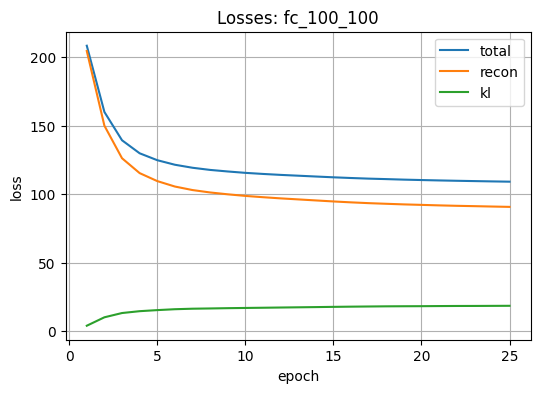

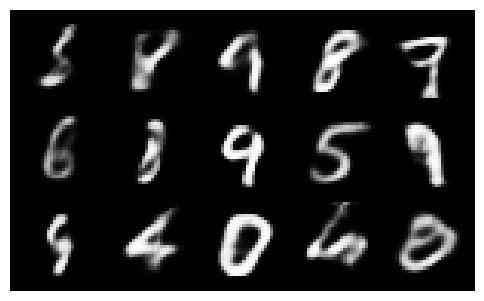

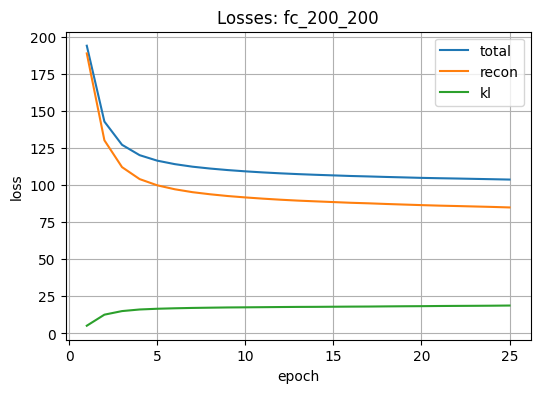

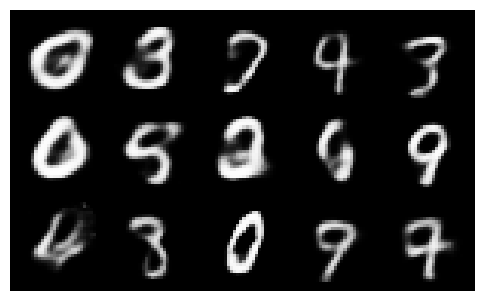

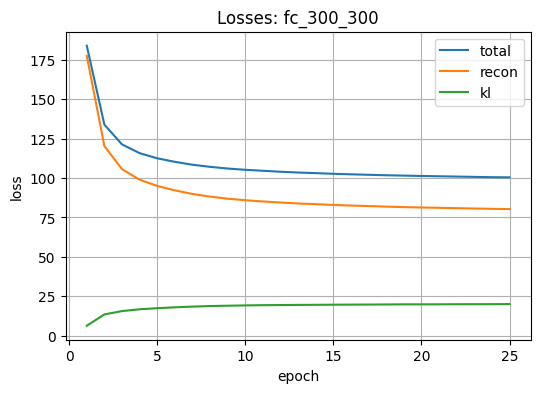

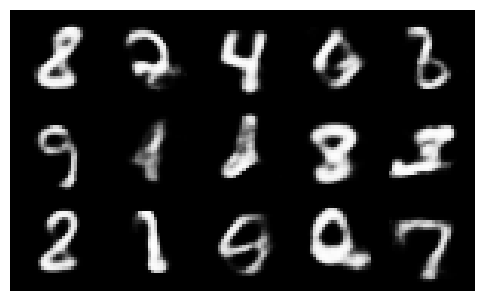

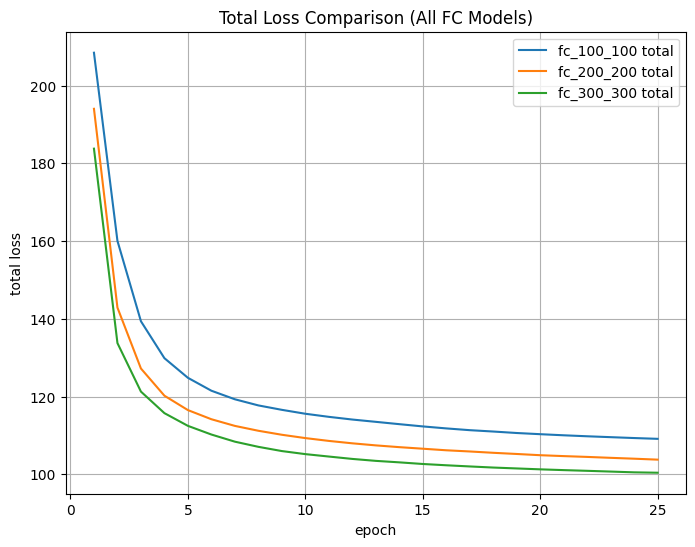

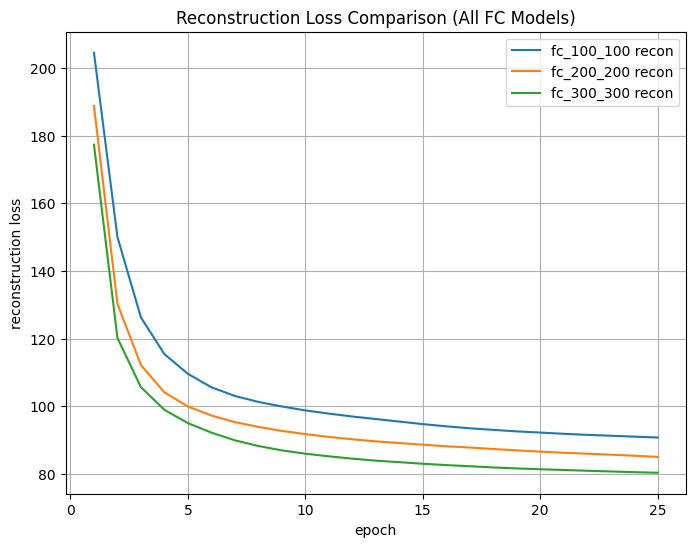

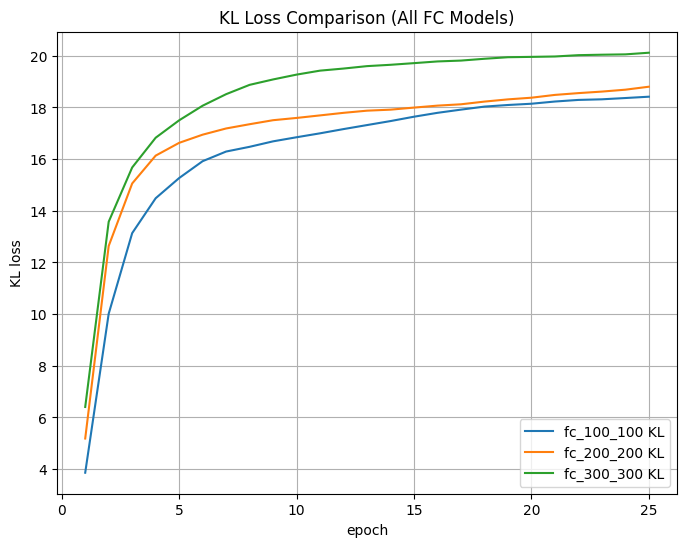

In [28]:
def plot_history(history, title="Loss"):
    plt.figure(figsize=(6,4))
    plt.plot(history["epoch"], history["total_loss"], label="total")
    plt.plot(history["epoch"], history["recon_loss"], label="recon")
    plt.plot(history["epoch"], history["kl_loss"], label="kl")
    plt.xlabel("epoch"); plt.ylabel("loss")
    plt.legend(); plt.title(title)
    plt.grid(True)
    plt.show()

def sample_and_show_fc(model: FCVAE, num_samples=15):
    model.eval()
    z = torch.randn(num_samples, model.latent_dim).to(device)
    with torch.no_grad():
        xhat_flat = model.decode(z)
    xhat_imgs = xhat_flat.view(-1,1,28,28).cpu()
    grid = utils.make_grid(xhat_imgs, nrow=5, padding=2)
    plt.figure(figsize=(6,6)); plt.axis('off')
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray'); plt.show()

for name, hist in histories.items():
    plot_history(hist, title=f"Losses: {name}")
    sample_and_show_fc(fc_models[name], num_samples=15)

names = list(histories.keys())

plt.figure(figsize=(8,6))
for name in names:
    plt.plot(histories[name]["epoch"], histories[name]["total_loss"], label=f"{name} total")
plt.xlabel("epoch"); plt.ylabel("total loss")
plt.title("Total Loss Comparison (All FC Models)")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for name in names:
    plt.plot(histories[name]["epoch"], histories[name]["recon_loss"], label=f"{name} recon")
plt.xlabel("epoch"); plt.ylabel("reconstruction loss")
plt.title("Reconstruction Loss Comparison (All FC Models)")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
for name in names:
    plt.plot(histories[name]["epoch"], histories[name]["kl_loss"], label=f"{name} KL")
plt.xlabel("epoch"); plt.ylabel("KL loss")
plt.title("KL Loss Comparison (All FC Models)")
plt.legend(); plt.grid(True)
plt.show()


Conv VAE training

Epoch 1/25 - total: 197.7355, recon: 194.5689, kl: 3.1666
Epoch 2/25 - total: 152.3012, recon: 143.3722, kl: 8.9290
Epoch 3/25 - total: 134.8265, recon: 124.5296, kl: 10.2969
Epoch 4/25 - total: 128.1698, recon: 117.3371, kl: 10.8326
Epoch 5/25 - total: 124.5914, recon: 113.1161, kl: 11.4752
Epoch 6/25 - total: 120.4732, recon: 108.0578, kl: 12.4153
Epoch 7/25 - total: 117.4644, recon: 104.6607, kl: 12.8037
Epoch 8/25 - total: 115.7101, recon: 102.6862, kl: 13.0239
Epoch 9/25 - total: 114.3280, recon: 101.1562, kl: 13.1718
Epoch 10/25 - total: 113.4468, recon: 100.1519, kl: 13.2949
Epoch 11/25 - total: 112.6649, recon: 99.2489, kl: 13.4159
Epoch 12/25 - total: 111.8686, recon: 98.3550, kl: 13.5137
Epoch 13/25 - total: 111.4156, recon: 97.8450, kl: 13.5707
Epoch 14/25 - total: 110.8609, recon: 97.2444, kl: 13.6165
Epoch 15/25 - total: 110.4967, recon: 96.8370, kl: 13.6597
Epoch 16/25 - total: 110.0428, recon: 96.3261, kl: 13.7168
Epoch 17/25 - total: 109.7748, recon: 96.0047, kl: 13.770

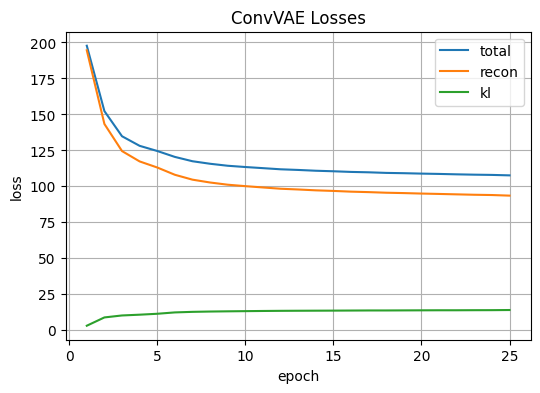

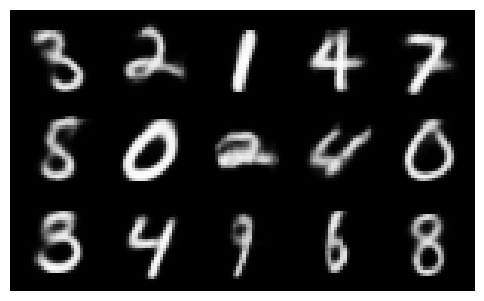

In [9]:
conv_latent_dim = 20
conv_epochs = 25
conv_model = ConvVAE(latent_dim=conv_latent_dim).to(device)
conv_optimizer = torch.optim.Adam(conv_model.parameters(), lr=1e-3)

conv_history = train_vae(conv_model, train_loader, conv_optimizer, conv_epochs, device)
torch.save(conv_model.state_dict(), "conv_vae.pth")
print("Saved conv_vae.pth")

plot_history(conv_history, title="ConvVAE Losses")
conv_model.eval()
with torch.no_grad():
    z = torch.randn(15, conv_latent_dim).to(device)
    xhat = conv_model.decode(z).cpu()
grid = utils.make_grid(xhat, nrow=5, padding=2)
plt.figure(figsize=(6,6)); plt.axis('off')
plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray'); plt.show()


Classifier network

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3,1,1)
        self.conv2 = nn.Conv2d(32,64,3,1,1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

clf = SimpleCNN().to(device)
opt = torch.optim.Adam(clf.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs_clf = 5
for epoch in range(epochs_clf):
    clf.train()
    running = 0.0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        out = clf(x)
        loss = criterion(out, y)
        loss.backward()
        opt.step()
        running += loss.item()
    print(f"Classifier epoch {epoch+1}/{epochs_clf}, loss: {running/len(train_loader):.4f}")

torch.save(clf.state_dict(), "mnist_clf.pth")

Classifier epoch 1/5, loss: 0.1945
Classifier epoch 2/5, loss: 0.0484
Classifier epoch 3/5, loss: 0.0312
Classifier epoch 4/5, loss: 0.0214
Classifier epoch 5/5, loss: 0.0157


4.latent vectors from the prior N(0,I) and decoding them using the trained convolutional VAE

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


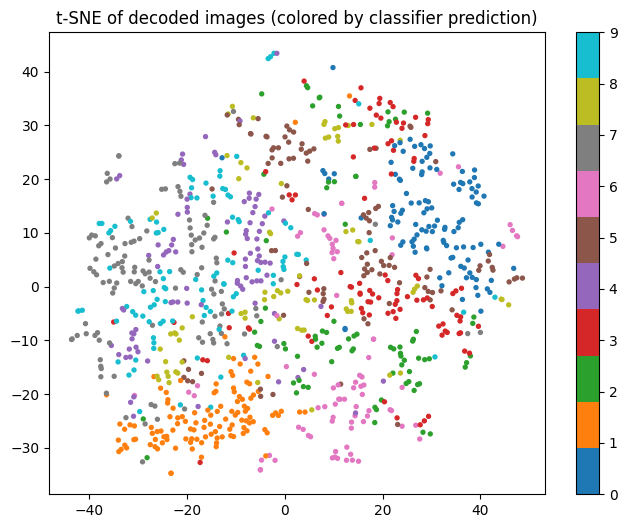

In [13]:
conv_model.to(device).eval()
clf.to(device).eval()
n_samples = 1000
with torch.no_grad():
    zs = torch.randn(n_samples, conv_latent_dim).to(device)
    decoded = conv_model.decode(zs).cpu()
with torch.no_grad():
    preds_logits = clf(decoded.to(device))
    preds = preds_logits.argmax(dim=1).cpu().numpy()
decoded_flat = decoded.view(n_samples, -1).numpy()
decoded_flat = StandardScaler().fit_transform(decoded_flat)
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
z2 = tsne.fit_transform(decoded_flat)
plt.figure(figsize=(8,6))
scatter = plt.scatter(z2[:,0], z2[:,1], c=preds, cmap="tab10", s=8)
plt.colorbar(scatter, ticks=range(10)); plt.title("t-SNE of decoded images (colored by classifier prediction)")
plt.show()

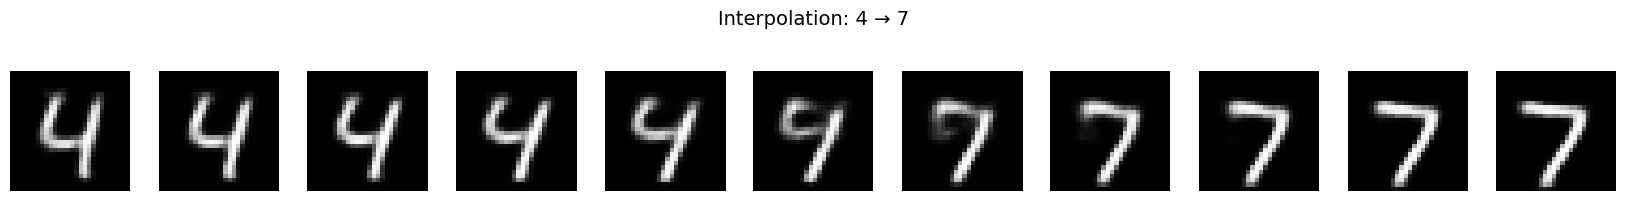

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def interpolate_mu(model, test_loader, device, digit_a=4, digit_b=7, n_steps=11):
    model.eval()
    img_a = img_b = None
    for imgs, labels in test_loader:
        for i, lab in enumerate(labels):
            if lab.item() == digit_a and img_a is None:
                img_a = imgs[i].unsqueeze(0).to(device)
            if lab.item() == digit_b and img_b is None:
                img_b = imgs[i].unsqueeze(0).to(device)
        if img_a is not None and img_b is not None:
            break
    if img_a is None or img_b is None:
        raise ValueError("Digits not found in test set! Try different digits.")
    with torch.no_grad():
        mu_a, logvar_a = model.encode(img_a)
        mu_b, logvar_b = model.encode(img_b)
    alphas = np.linspace(0, 1, n_steps)
    decoded_imgs = []
    with torch.no_grad():
        for a in alphas:
            z = (1 - a) * mu_a + a * mu_b
            x_hat = model.decode(z).cpu().squeeze(0)
            decoded_imgs.append(x_hat)
    fig, axs = plt.subplots(1, n_steps, figsize=(n_steps * 1.5, 2))
    fig.suptitle(f"Interpolation: {digit_a} → {digit_b}", fontsize=14)
    for i in range(n_steps):
        axs[i].imshow(decoded_imgs[i].squeeze(), cmap="gray")
        axs[i].axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()
interpolate_mu(conv_model, test_loader, device, digit_a=4, digit_b=7, n_steps=11)


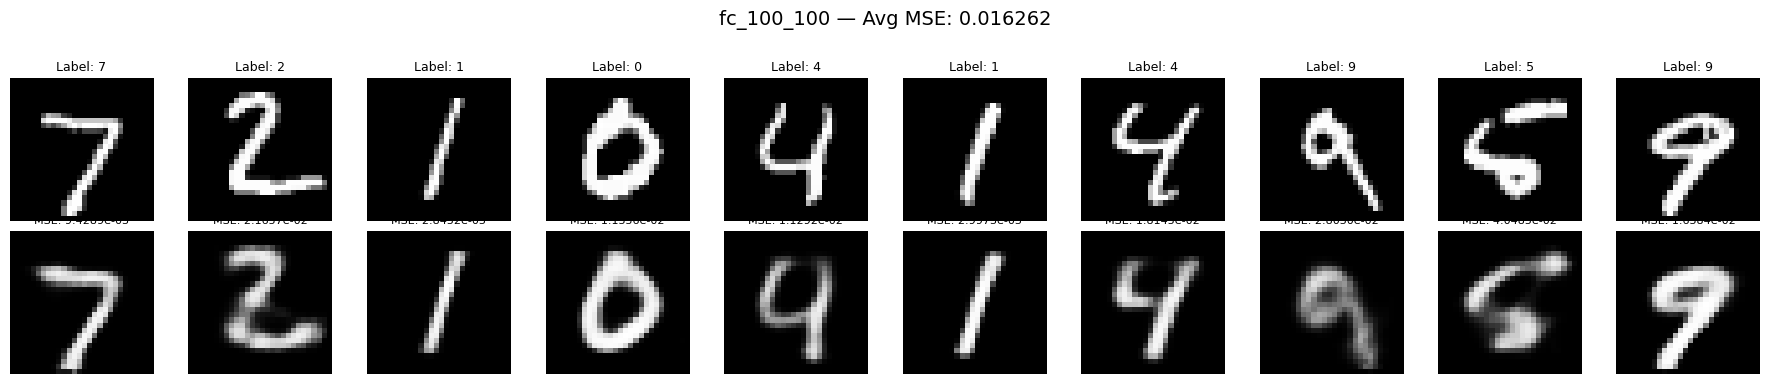

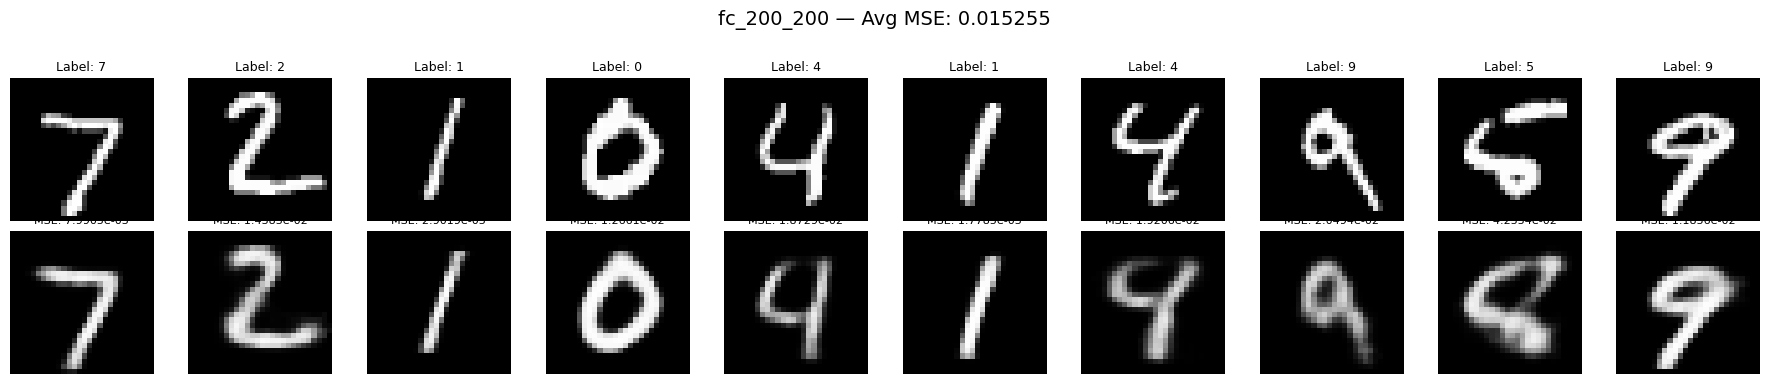

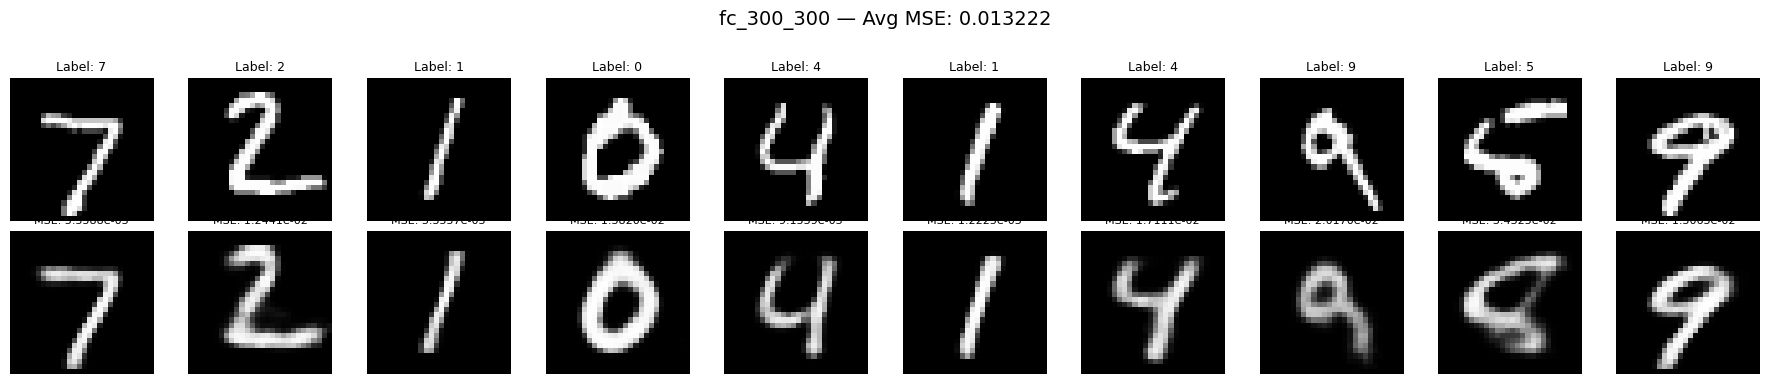

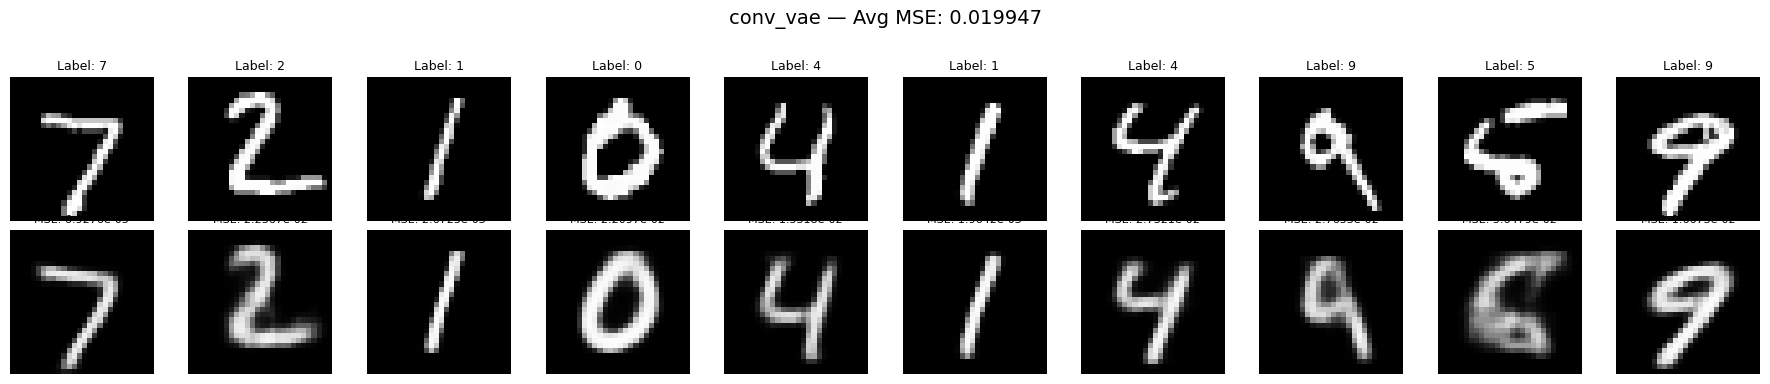

In [25]:
import matplotlib.pyplot as plt
import torch
from torchvision import utils
import numpy as np

def compare_reconstructions(models_dict, test_loader, device, n_display=10):
    model_names = list(models_dict.keys())
    test_iter = iter(test_loader)
    images, labels = next(test_iter)
    images = images.to(device)
    labels = labels.numpy()
    batch_size = images.shape[0]
    n_display = min(n_display, batch_size)
    imgs = images[:n_display]
    lbls = labels[:n_display]
    results = {}
    for name, model in models_dict.items():
        model = model.to(device)
        model.eval()
        with torch.no_grad():
            if isinstance(model, FCVAE):
                imgs_flat = imgs.view(imgs.size(0), -1)
                recon_flat, mu, logvar = model(imgs_flat)
                recon_imgs = recon_flat.view(-1,1,28,28)
            else:
                recon_imgs, mu, logvar = model(imgs)
            recon_cpu = recon_imgs.detach().cpu()
            mse_per_image = ((recon_cpu - imgs.cpu())**2).view(recon_cpu.size(0), -1).mean(dim=1).numpy()
            avg_mse = mse_per_image.mean()
            results[name] = {
                "recon": recon_cpu,
                "mse_per_image": mse_per_image,
                "avg_mse": avg_mse
            }

    for name in model_names:
        recon_cpu = results[name]["recon"]
        avg_mse = results[name]["avg_mse"]
        title = f"{name} — Avg MSE: {avg_mse:.6f}"
        fig, axs = plt.subplots(2, n_display, figsize=(n_display*1.8, 4))
        fig.suptitle(title, fontsize=14)

        for i in range(n_display):
            ax = axs[0, i] if n_display > 1 else axs[0]
            ax.imshow(imgs[i].cpu().squeeze(), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_ylabel("Ground truth", fontsize=10)
            ax2 = axs[1, i] if n_display > 1 else axs[1]
            ax2.imshow(recon_cpu[i].squeeze(), cmap='gray', vmin=0, vmax=1)
            ax2.axis('off')
            if i == 0:
                ax2.set_ylabel("Reconstruction", fontsize=10)
            ax.set_title(f"Label: {lbls[i]}", fontsize=9)
            ax2.set_title(f"MSE: {results[name]['mse_per_image'][i]:.4e}", fontsize=8)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

models_to_compare = {}
models_to_compare.update(fc_models)
models_to_compare["conv_vae"] = conv_model

compare_reconstructions(models_to_compare, test_loader, device, n_display=10)
